In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json

In [3]:
# label_folder = r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\label\custom'
# image_folder = r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\image\official'

label_folder = r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\label\custom'
image_folder = r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\image\official'

In [5]:
# def create_1D_centerness(s,S,e,E):
#     m = (s+e)/2
#     M = int(m)
#     rep = np.concatenate([np.arange(S+1,M+1),np.array([m]),np.arange(M+1,E+1)])
    
#     line = np.fmin(rep-s,e-rep)/np.fmax(rep-s,e-rep)
#     return line

def get_patches_and_loc(ltwh,map_size):
    l,t,w,h = ltwh*map_size
    
    r = l+w
    cx = (l+r)/2
    
    b = t+h
    cy = (t+b)/2
    
    L = int(l)
    Cx = int(cx)
    T = int(t)
    R = int(r)
    Cy = int(cy)
    B = int(b)
    
    #create center-ness patch
    horizon = np.concatenate([np.arange(L+1,Cx+1),np.array([cx]),np.arange(Cx+1,R+1)])
    horizon = np.fmin(horizon-l,r-horizon)/np.fmax(horizon-l,r-horizon)
    vertical = np.concatenate([np.arange(T+1,Cy+1),np.array([cy]),np.arange(Cy+1,B+1)])
    vertical = np.fmin(vertical-t,b-vertical)/np.fmax(vertical-t,b-vertical)
    centerness = np.sqrt(horizon*vertical[:,None])
    
    #create ground truth center patch
    gt_center = np.zeros_like(centerness,dtype=float)
    gt_center[Cy-T,Cx-L] = 1.
    
    #create determine patch
    grid_center_coor = np.stack(np.broadcast_arrays((np.arange(L,R+1)+0.5),(np.arange(T,B+1)+0.5)[:,None]),axis=-1)/map_size
    grid_center_coor = grid_center_coor[:,:,None,:]
    bbox_rect_coor = np.array([[l,t],[r,t],[r,b],[l,b]])/map_size
    bbox_rect_coor = bbox_rect_coor[None,None,:,:]
    determine = np.max(np.abs(grid_center_coor-bbox_rect_coor)*2,axis=-1)
    determine = np.max(determine,axis=-1)
    
    
    
    return L,R,T,B,centerness,gt_center,determine


# def get_patches_and_loc(ltwh,map_size):
#     l,t,w,h = ltwh*map_size
    
#     r = l+w
#     b = t+h
    
#     L = int(l)
#     T = int(t)
#     R = int(r)
#     B = int(b)
    
#     centerness_hor = create_1D_centerness(l,L,r,R)
#     centerness_ver = create_1D_centerness(t,T,b,B)
#     centerness_patch = np.sqrt(centerness_hor*centerness_ver[:,None])
    
#     grid_center_coor = np.stack(np.broadcast_arrays((np.arange(L,R+1)+0.5),(np.arange(T,B+1)+0.5)[:,None]),axis=-1)/map_size
#     grid_center_coor = grid_center_coor[:,:,None,:]
#     bbox_rect_coor = np.array([[l,t],[r,t],[r,b],[l,b]])/map_size
#     bbox_rect_coor = bbox_rect_coor[None,None,:,:]
#     determine_patch = np.max(np.abs(grid_center_coor-bbox_rect_coor)*2,axis=-1)
#     determine_patch = np.max(determine_patch,axis=-1)
    
#     return L,R,T,B,centerness_patch,determine_patch

In [6]:
# label_id = 2908
label_id = 56
label_path = pathlib.Path(label_folder,f'img_{label_id}.json')
label = json.loads(label_path.read_text(encoding='utf8'))
image_byte = tf.io.read_file(pathlib.Path(image_folder,label['ImageName']).as_posix())
image = tf.image.decode_jpeg(image_byte)
image = tf.image.convert_image_dtype(image,tf.float32)
image = tf.image.resize(image,(1024,1024))

image_size = 1024
map_size = 128
determine_range = [16,32,64,128,256,512,1024]


determine_range = [(determine_range[i-1]+1,d) if i != 0 else (0,d) for i,d in enumerate(determine_range)]
determine_range = [(s/image_size,e/image_size) for s,e in determine_range]


categories = np.array([b['type'] for b in label['bboxes']])
rectangles_ltwh = np.array([b['rectangle']['ltwh'] for b in label['bboxes']])
rectangles_ltwh[:,2:] = rectangles_ltwh[:,2:]-1e-4
polygons_points =  np.array([b['polygon']['points'] for b in label['bboxes']])


label = np.

centerness = [np.zeros((map_size,map_size)) for _ in range(len(determine_range))]
gt_center = [np.zeros((map_size,map_size)) for _ in range(len(determine_range))]

for ltwh in ltwh_stack:
    L, Cx, R, T, Cy, B, centerness_patch, determine_patch = get_patches_and_loc(ltwh, map_size)
    print(ltwh*1024)
    display(determine_patch*1024)
    for i,dr in enumerate(determine_range):
        mask = (dr[0]<=determine_patch)&(determine_patch<=dr[1])
        print(dr[0]*1024,dr[1]*1024)
        display(mask)
        centerness[i][T:B+1,L:R+1] = np.where(
            (centerness_patch>centerness[i][T:B+1,L:R+1])&mask,
            centerness_patch,
            centerness[i][T:B+1,L:R+1])
    
#     bbox_loc[T:B+1,L:R+1,:] = np.concatenate([center,ltwh[2:]],axis=-1)
#     bbox_loc_stack.append(bbox_loc)
    
#     centerness[T:B+1,L:R+1] = patch
#     centerness_stack.append(centerness)
    
#     gt_center[int(cy),int(cx)] = 1.

# bbox_loc_stack = np.stack(bbox_loc_stack,axis=0)
# centerness_stack = np.stack(centerness_stack,axis=0)

# gt_center = np.zeros((map_size,map_size))
# gt_center[(center_stack[:,1]*map_size).astype(int),(center_stack[:,0]*map_size).astype(int)] = 1.

# centerness = np.max(centerness_stack,axis=0)

# plt.figure(figsize=(20,20))
# plt.imshow(centerness)
# plt.show()
# plt.figure(figsize=(10,10))
# plt.imshow(image)
# plt.show()

NameError: name 'ltwh_stack' is not defined

In [7]:
categories = np.array([b['type'] for b in label['bboxes']])
rectangles = np.array([b['rectangle']['ltwh'] for b in label['bboxes']])
rectangles[:,2:] = rectangles[:,2:]-1e-4
polygons =  np.array([b['polygon']['points'] for b in label['bboxes']])

In [9]:
categories

array([0, 2, 2, 2, 2, 2, 2, 5, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
polygons

array([[[0.32714844, 0.2014652 ],
        [0.36132812, 0.2007326 ],
        [0.36328125, 0.37289377],
        [0.33007812, 0.37069597]],

       [[0.33105469, 0.43003663],
        [0.36914062, 0.43296703],
        [0.36914062, 0.44835165],
        [0.33203125, 0.44615385]],

       [[0.33203125, 0.44688645],
        [0.39550781, 0.45201465],
        [0.39550781, 0.46446886],
        [0.33203125, 0.46007326]],

       [[0.33203125, 0.41684982],
        [0.35253906, 0.41831502],
        [0.35253906, 0.42930403],
        [0.33203125, 0.42857143]],

       [[0.35644531, 0.41978022],
        [0.37890625, 0.42051282],
        [0.37792969, 0.43150183],
        [0.35546875, 0.43003663]],

       [[0.37011719, 0.43663004],
        [0.38867188, 0.43663004],
        [0.38867188, 0.44615385],
        [0.37109375, 0.44542125]],

       [[0.39160156, 0.43516484],
        [0.41503906, 0.43663004],
        [0.41503906, 0.44835165],
        [0.39160156, 0.44688645]],

       [[0.39941406, 0.46739927],


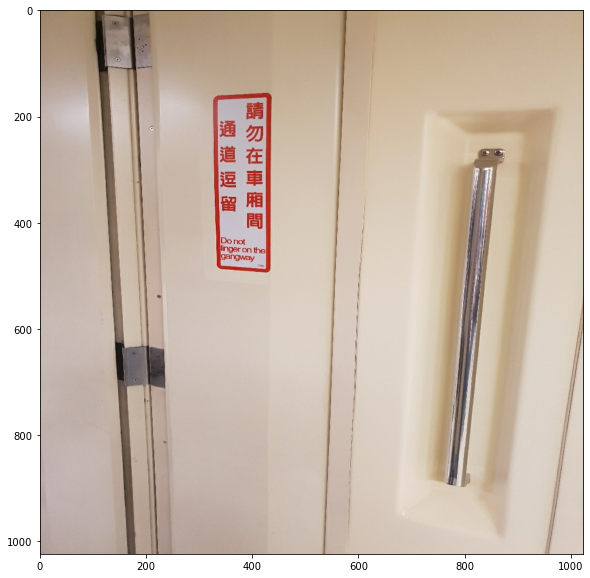

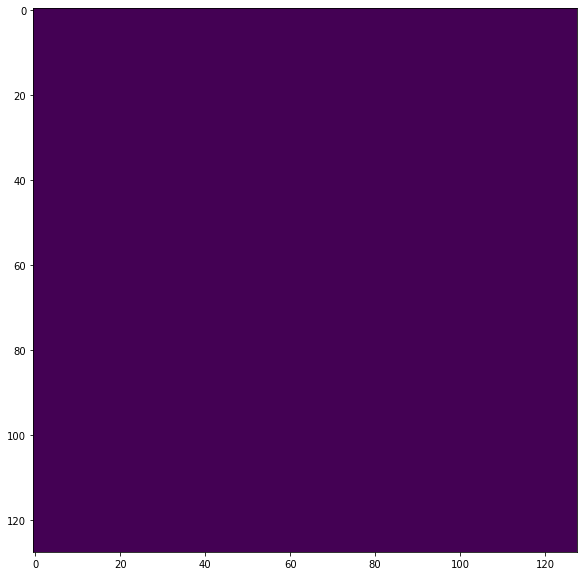

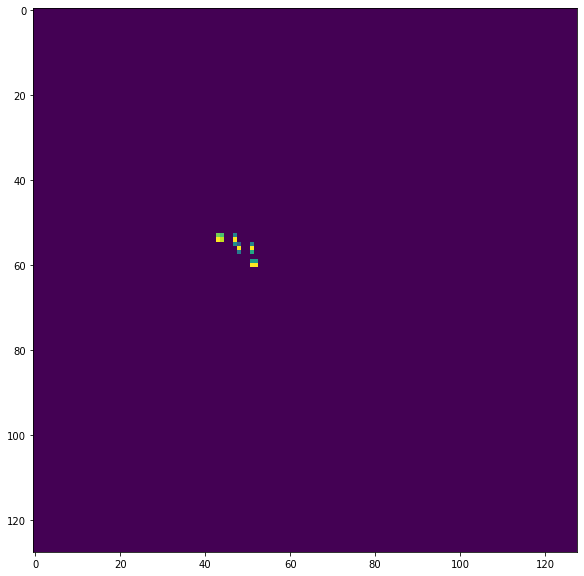

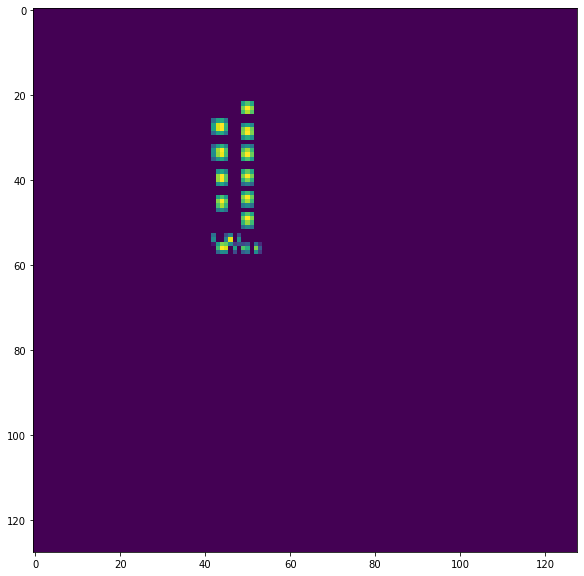

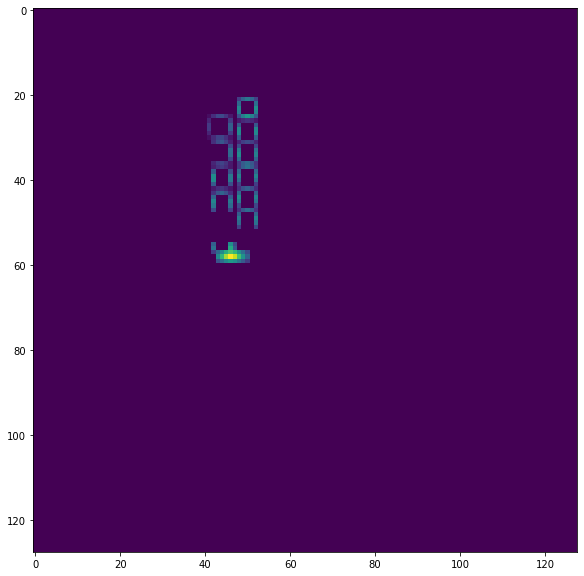

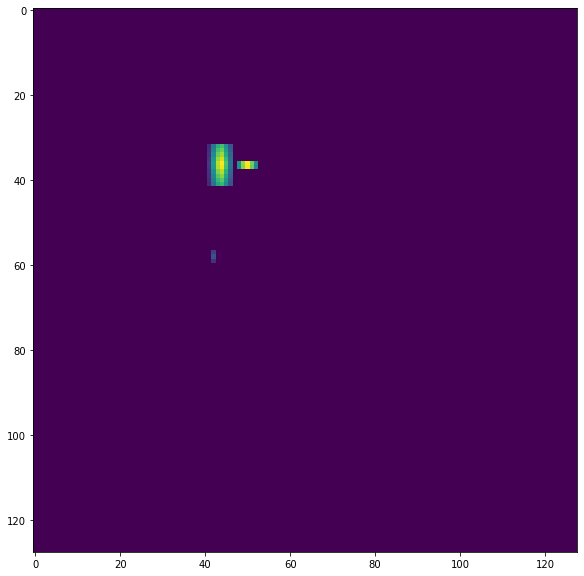

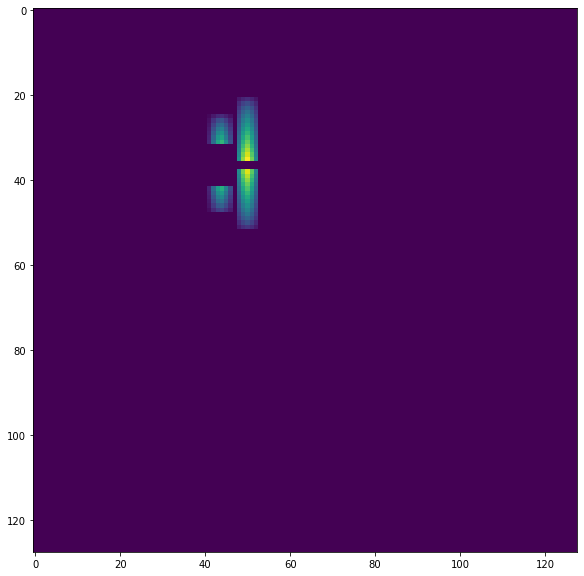

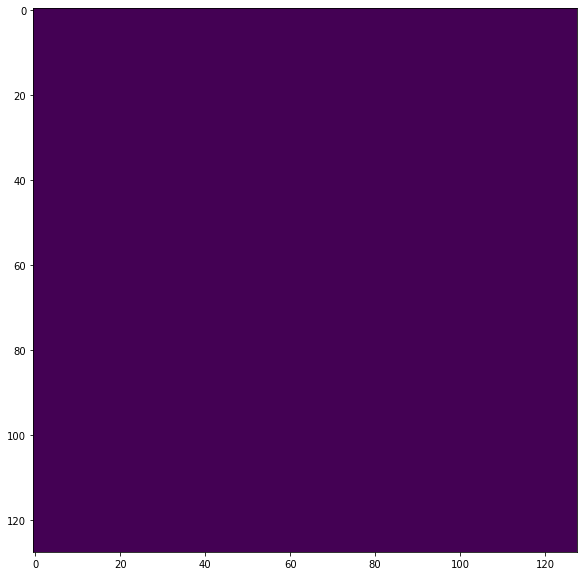

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()
for c in centerness:
    plt.figure(figsize=(10,10))
    plt.imshow(c)
    plt.show()

In [12]:
for c in centerness:
    display(np.where(np.isclose(c,1)))

(array([], dtype=int64), array([], dtype=int64))

(array([54, 54, 56, 56, 60], dtype=int64),
 array([43, 47, 48, 51, 51], dtype=int64))

(array([23, 27, 29, 33, 34, 39, 39, 44, 45, 49, 56], dtype=int64),
 array([50, 44, 50, 44, 50, 44, 50, 50, 44, 50, 44], dtype=int64))

(array([58], dtype=int64), array([46], dtype=int64))

(array([36, 36], dtype=int64), array([44, 50], dtype=int64))

(array([], dtype=int64), array([], dtype=int64))

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
centerness_patch
determin_patch

In [ ]:
[centerness,gt_center,normalized_dx,normalized_dy,w,h]